In [1]:
# env sctk2

%load_ext autoreload
%autoreload 2

import os, re, gc 
#joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sn
import anndata
import scanpy as sc
import sctk as sk
import gseapy as gp
from gseapy.plot import barplot, dotplot


rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42
expr_cmap = sk.expression_colormap()
np.set_printoptions(linewidth=150)

import numpy_groupies as npg
#from plotnine import ggplot, aes
#import plotnine as pln
from matplotlib.colors import ListedColormap

import matplotlib
import matplotlib.cm as cm

from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import pearsonr, spearmanr

import scipy.sparse as sp

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

scanpy==1.9.3 anndata==0.8.0 umap==0.5.1 numpy==1.23.4 scipy==1.9.3 pandas==1.5.1 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.8


In [3]:
root_path = '/lustre/scratch126/cellgen/team298/hg6/Fetal_skin/data/final/'
save_path = '/home/jovyan/projects/skin/fetal_skin/'
sc.settings.figdir = save_path + 'figures/other plots/'

# Load and configure data object

In [4]:
#load pooled prenatal skin, healthy adult and skin organoid object

pooled_object = 'pooled_fetal_organoid_adult.processed.h5ad'
pooled_path = root_path + pooled_object
pdata = sc.read(pooled_path)
pdata

AnnData object with n_obs × n_vars = 506107 × 46794
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'day', 'sample_id', 'version', 'week', 'nh3_annot1', 'log1p_n_counts', 'log1p_n_genes', 'n_counts_mito', 'n_counts_ribo', 'n_

In [5]:
print(list(pdata.obs['dataset'].unique()))

['fetal', 'organoid', 'adult']


In [6]:
#slice to prenetal/fetal skin only and remove genes with counts<1
keep1 = ['fetal']
pdata_fetal = pdata[pdata.obs['dataset'].isin(keep1)]
sc.pp.filter_genes(pdata_fetal, min_counts=1, min_cells=None, inplace=True)
pdata_fetal

filtered out 18015 genes that are detected in less than 1 counts


AnnData object with n_obs × n_vars = 186533 × 28779
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'day', 'sample_id', 'version', 'week', 'nh3_annot1', 'log1p_n_counts', 'log1p_n_genes', 'n_counts_mito', 'n_counts_ribo', 'n_

In [7]:
#slice to organoid skin only and check 'day'
keep2 = ['organoid']
pdata_org = pdata[pdata.obs['dataset'].isin(keep2)]
print(list(pdata_org.obs['day'].unique()))

['day-133', 'day-29', 'day-48', 'day-85', 'day-13']


In [8]:
#slice skin organoid object to remove day-13 only and and remove genes with counts<1
pdata_org = pdata_org[pdata_org.obs['day']!='day-13']
print(list(pdata_org.obs['day'].unique()))
sc.pp.filter_genes(pdata_org, min_counts=1, min_cells=None, inplace=True)
pdata_org

['day-133', 'day-29', 'day-48', 'day-85']
filtered out 18681 genes that are detected in less than 1 counts


AnnData object with n_obs × n_vars = 114278 × 28113
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'day', 'sample_id', 'version', 'week', 'nh3_annot1', 'log1p_n_counts', 'log1p_n_genes', 'n_counts_mito', 'n_counts_ribo', 'n_

In [9]:
#check data counts
pdata_fetal.X.data

array([2.2455943, 0.989481 , 0.989481 , ..., 1.6292564, 1.6292564, 1.6292564], dtype=float32)

In [10]:
pdata_fetal.X.max()

11.004526

In [11]:
pdata_org.X.data

array([0.6374563, 0.6374563, 0.6374563, ..., 1.36667  , 1.36667  , 1.36667  ], dtype=float32)

In [12]:
pdata_org.X.max()

8.528311

In [13]:
#re concatenate data to have prenatal skin/organoid object keeping only intersect of genes
import anndata as ad

pdata2 = ad.concat([pdata_fetal, pdata_org])
pdata2

AnnData object with n_obs × n_vars = 300811 × 19372
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'day', 'sample_id', 'version', 'week', 'nh3_annot1', 'log1p_n_counts', 'log1p_n_genes', 'n_counts_mito', 'n_counts_ribo', 'n_

In [14]:
# check annotations
print(list(pdata2.obs['joint_annotation_20220202'].unique()))
print(list(pdata2.obs['org_annot0'].unique()))

['LYVE1++ macrophage', 'Monocyte (activated/differentiating)', 'Eo/baso/mast cell progenitor', 'DC2', 'TREM2+ macrophage', 'Monocyte precursor', 'Monocyte', 'WNT2+ fibroblast', 'Iron-recycling macrophage', 'NK cell', 'B cell', 'LTi', 'ILC3', 'Inflammatory DC', 'MEMP - Early erythroid', 'CD4 T cell', 'Pro B cell', 'HSC', 'Pre B cell', 'MHCII+ macrophage', 'LYVE1-hi LE', 'Pre pro B cell', 'Innate T type1', 'CD8 T cell', 'Myocytes', 'pDC', 'Mast cell (most mature)', 'DC1', 'Mast cell (medium)', 'Capillaries', 'Neutrophil2', 'Capillary arterioles', 'LC', 'Megakaryocyte', 'MEMP - Megak', 'Mast cell (earliest)', 'Erythroid (fetal)', 'Myoblasts', 'Myofibroblasts', 'Pre-dermal condensate', 'HOXC5+ early fibroblast', 'PEAR1+ fibroblast', 'Pericytes', 'FRZB+ early fibroblast', 'Early erythroid (embryonic)', 'Early myocytes', 'Neuron progenitors', 'Myelinating Schwann cells', 'Schwann/Schwann precursors', 'LMCD1+ mural cell', 'PLN+ mural cell', 'ILC2', 'Lymphoid progenitor', 'SPP1+ proliferating 

In [15]:
#create combined annotation column
pdata2.obs['new_combined_anno'] = pdata2.obs['joint_annotation_20220202']
cond = (pdata2.obs['new_combined_anno'] == 'nan')
pdata2.obs.loc[cond, 'new_combined_anno'] = pdata2.obs['org_annot0']
print(list(pdata2.obs['new_combined_anno'].unique()))

['LYVE1++ macrophage', 'Monocyte (activated/differentiating)', 'Eo/baso/mast cell progenitor', 'DC2', 'TREM2+ macrophage', 'Monocyte precursor', 'Monocyte', 'WNT2+ fibroblast', 'Iron-recycling macrophage', 'NK cell', 'B cell', 'LTi', 'ILC3', 'Inflammatory DC', 'MEMP - Early erythroid', 'CD4 T cell', 'Pro B cell', 'HSC', 'Pre B cell', 'MHCII+ macrophage', 'LYVE1-hi LE', 'Pre pro B cell', 'Innate T type1', 'CD8 T cell', 'Myocytes', 'pDC', 'Mast cell (most mature)', 'DC1', 'Mast cell (medium)', 'Capillaries', 'Neutrophil2', 'Capillary arterioles', 'LC', 'Megakaryocyte', 'MEMP - Megak', 'Mast cell (earliest)', 'Erythroid (fetal)', 'Myoblasts', 'Myofibroblasts', 'Pre-dermal condensate', 'HOXC5+ early fibroblast', 'PEAR1+ fibroblast', 'Pericytes', 'FRZB+ early fibroblast', 'Early erythroid (embryonic)', 'Early myocytes', 'Neuron progenitors', 'Myelinating Schwann cells', 'Schwann/Schwann precursors', 'LMCD1+ mural cell', 'PLN+ mural cell', 'ILC2', 'Lymphoid progenitor', 'SPP1+ proliferating 

# Pro- and anti- angiogenic factors

## DEGs computation between prenatal skin and skin organoid

In [21]:
list(pdata2.obs['dataset'].unique())

['fetal', 'organoid']

In [22]:
sc.tl.rank_genes_groups(pdata2, groupby = 'dataset', method = 'wilcoxon', key_added='rank_genes_groups_fs_or')

ranking genes
    finished: added to `.uns['rank_genes_groups_fs_or']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:19:06)


In [23]:
result = pdata2.uns['rank_genes_groups_fs_or']
groups = result['names'].dtype.names
DE = pd.DataFrame({group + '_' + key[:1]: result[key][group]
 for group in groups for key in ['names', 'logfoldchanges', 'pvals_adj']})
DE.head()

,fetal_n,fetal_l,fetal_p,organoid_n,organoid_l,organoid_p
0,ACTB,1.728426,0.0,MALAT1,1.707570,0.0
1,PFN1,2.002643,0.0,RPS2,1.455904,0.0
2,GABARAP,4.526878,0.0,GNAS,1.947703,0.0
3,ALDOA,2.743947,0.0,RPL15,0.842684,0.0
4,PCBP2,1.736592,0.0,RAC1,2.227098,0.0


In [24]:
#DE_path ="/home/jovyan/mount_farm/nfs/nfs/team298/hg6/Fetal_skin/out_files/DEGs_fetal_organoid_27032023.csv"
#DE.to_csv(DE_path)
DE.shape

(19372, 6)

## Genes of secreted proteins - secretory genes

In [25]:
#read in list of secreted proteins
protein = pd.read_csv('/nfs/team298/wt1/handover_skin/data/protein_class_Predicted.tsv', sep ='\t')
print(protein.shape)
protein.head()

(1903, 313)


,Gene,Gene synonym,Ensembl,Gene description,Uniprot,Chromosome,Position,Protein class,Biological process,Molecular function,...,Single Cell Type RNA - Smooth muscle cells [nTPM],Single Cell Type RNA - Spermatocytes [nTPM],Single Cell Type RNA - Spermatogonia [nTPM],Single Cell Type RNA - Squamous epithelial cells [nTPM],Single Cell Type RNA - Suprabasal keratinocytes [nTPM],Single Cell Type RNA - Syncytiotrophoblasts [nTPM],Single Cell Type RNA - T-cells [nTPM],Single Cell Type RNA - Theca cells [nTPM],Single Cell Type RNA - Undifferentiated cells [nTPM],Single Cell Type RNA - Urothelial cells [nTPM]
0,A1BG,NaN,ENSG00000121410,Alpha-1-B glycoprotein,P04217,19,58345178-58353492,"Plasma proteins, Predicted intracellular prote...",NaN,NaN,...,43.8,4.1,7.9,1.5,3.7,1.9,52.6,0.7,0.2,0.6
1,A2M,"CPAMD5, FWP007, S863-7",ENSG00000175899,Alpha-2-macroglobulin,P01023,12,9067664-9116229,"Cancer-related genes, Candidate cardiovascular...",NaN,"Protease inhibitor, Serine protease inhibitor",...,328.0,2.7,8.8,8.2,14.1,4.1,13.0,73.3,0.0,3.6
2,A2ML1,"CPAMD9, FLJ25179, p170",ENSG00000166535,Alpha-2-macroglobulin like 1,A8K2U0,12,8822621-8887001,"Disease related genes, Predicted intracellular...",NaN,"Protease inhibitor, Serine protease inhibitor",...,0.3,1.0,0.4,127.6,12.6,0.1,0.1,1.9,0.0,8.2
3,AADACL2,MGC72001,ENSG00000197953,Arylacetamide deacetylase like 2,Q6P093,3,151733916-151761339,Predicted secreted proteins,NaN,Hydrolase,...,0.1,0.0,0.0,0.1,30.7,0.1,0.1,0.0,0.0,0.0
4,ABHD15,NaN,ENSG00000168792,Abhydrolase domain containing 15,Q6UXT9,17,29560547-29567037,Predicted secreted proteins,NaN,Hydrolase,...,1.9,0.8,0.6,2.0,2.4,0.3,11.8,4.5,7.4,1.2


In [26]:
#Select only secretory genes in prenatal skin
DE_filt = DE[DE['fetal_n'].isin(protein['Gene'])]
print(DE_filt.shape)
DE_filt.head()

(1502, 6)


,fetal_n,fetal_l,fetal_p,organoid_n,organoid_l,organoid_p
22,PPIA,0.818029,0.0,RPS20,1.746284,0.0
38,B2M,1.299107,0.0,UBE2M,3.236295,0.0
40,MTRNR2L12,2.191779,0.0,EPB41L4A-AS1,1.557084,0.0
41,CST3,1.804769,0.0,NDUFC2,1.607353,0.0
53,IGF2,2.253153,0.0,RPL6,0.556191,0.0


In [28]:
#Identify significantly upregulated secretory genes
DE_up = DE_filt[(DE_filt['fetal_l']>0) & (DE['fetal_p']<0.05)]
DE_up.drop(columns=['organoid_n', 'organoid_l', 'organoid_p'], inplace=True)
print(DE_up.shape)
DE_up.head()

#DE_up_path ="/home/jovyan/mount_farm/nfs/nfs/team298/hg6/Fetal_skin/out_files/DEGs_fetal_upregulated.csv"
#DE_up.to_csv(DE_up_path)

(470, 3)


,fetal_n,fetal_l,fetal_p
22,PPIA,0.818029,0.0
38,B2M,1.299107,0.0
40,MTRNR2L12,2.191779,0.0
41,CST3,1.804769,0.0
53,IGF2,2.253153,0.0


In [29]:
#Identify significantly downregulated secretory genes
DE_down = DE_filt[(DE_filt['fetal_l']<0) & (DE['fetal_p']<0.05)]
DE_down.drop(columns=['organoid_n', 'organoid_l', 'organoid_p'], inplace=True)
print(DE_down.shape)
DE_down.head()

#DE_down_path ="/home/jovyan/mount_farm/nfs/nfs/team298/hg6/Fetal_skin/out_files/DEGs_fetal_downregulated.csv"
#DE_down.to_csv(DE_down_path)

(399, 3)


,fetal_n,fetal_l,fetal_p
5217,HMGB1,-0.000891,0.001658
12285,IGFBPL1,-2.501255,0.048318
12287,SSC4D,-0.729572,0.048091
12377,CHAD,-1.286093,0.032872
12389,TF,-0.426889,0.032023


## Angiogenesis-related secretory genes

### Lists of significantly up/down-regulated secretory genes

In [30]:
#Generate lists of signifcantly up/down-regulated genes
glist_down=list(DE_down['fetal_n'])
print(len(glist_down))

glist_up=list(DE_up['fetal_n'])
print(len(glist_up))

399
470


In [31]:
#check for intersection - should be null
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3
 

print(intersection(glist_down, glist_up))

[]


In [34]:
#remove MT and Ribo genes from above gene lists in preparation for GSEApy analysis
glist_down_filt= [x for x in glist_down if not x.startswith('MT-')]
glist_down_filt= [x for x in glist_down_filt if not x.startswith('RPL')]
glist_down_filt= [x for x in glist_down_filt if not x.startswith('RPS')]
print(len(glist_down_filt))

glist_up_filt= [x for x in glist_up if not x.startswith('MT-')]
glist_up_filt= [x for x in glist_up_filt if not x.startswith('RPL')]
glist_up_filt= [x for x in glist_up_filt if not x.startswith('RPS')]
print(len(glist_up_filt))


399
470


### GSEApy analysis

In [35]:
# run enrichr for 1. up-regulated secretory genes and 2. downregulated secretory genes
# if you are only intrested in dataframe that enrichr returned, please set no_plot=True

enr_go_down = gp.enrichr(gene_list=glist_down_filt,
                 gene_sets=['GO_Biological_Process_2021'],
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 #background='hsapiens_gene_ensembl',
                 #description='fs_sec_prot',
                 outdir='/home/jovyan/mount_farm/nfs/nfs/team298/out_files/gsea_output_24052023/',
                 no_plot=True,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

enr_hm_down = gp.enrichr(gene_list=glist_down_filt,
                 gene_sets=['MSigDB_Hallmark_2020'],
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 #background='hsapiens_gene_ensembl',
                 #description='fs_sec_prot',
                 outdir='/home/jovyan/mount_farm/nfs/nfs/team298/out_files/gsea_output_24052023/',
                 no_plot=True,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

enr_go_up = gp.enrichr(gene_list=glist_up_filt,
                 gene_sets=['GO_Biological_Process_2021'],
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 #background='hsapiens_gene_ensembl',
                 #description='test_name',
                 outdir='/home/jovyan/mount_farm/nfs/nfs/team298/out_files/gsea_output_24052023/',
                 no_plot=True,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

enr_hm_up = gp.enrichr(gene_list=glist_up_filt,
                 gene_sets=['MSigDB_Hallmark_2020'],
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 #background='hsapiens_gene_ensembl',
                 #description='test_name',
                 outdir='/home/jovyan/mount_farm/nfs/nfs/team298/out_files/gsea_output_24052023/',
                 no_plot=True,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )


In [36]:
enr_go_down.res2d

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,extracellular matrix organization (GO:0030198),71/300,7.223797e-56,1.643414e-52,0,0,18.311482,2324.960916,APP;ECM2;COL16A1;COL14A1;ELN;TNC;LAMC2;FGF2;LO...
1,GO_Biological_Process_2021,extracellular structure organization (GO:0043062),60/216,1.155629e-51,1.190908e-48,0,0,22.061493,2587.530638,APP;ECM2;COL16A1;COL14A1;ELN;TNC;LAMC2;FGF2;LO...
2,GO_Biological_Process_2021,external encapsulating structure organization ...,60/217,1.570428e-51,1.190908e-48,0,0,21.919847,2564.194444,APP;ECM2;COL16A1;COL14A1;ELN;TNC;LAMC2;FGF2;LO...
3,GO_Biological_Process_2021,collagen fibril organization (GO:0030199),30/89,5.134953e-29,2.920505e-26,0,0,26.928483,1754.091669,COL17A1;COL16A1;COL14A1;COL11A1;COL11A2;LAMA3;...
4,GO_Biological_Process_2021,skeletal system development (GO:0001501),33/158,2.488759e-24,1.132386e-21,0,0,14.048262,763.526678,PKDCC;UCMA;HHIP;COL11A2;XYLT1;STC1;TNFRSF11B;H...
...,...,...,...,...,...,...,...,...,...,...
2270,GO_Biological_Process_2021,ubiquitin-dependent protein catabolic process ...,1/354,9.992491e-01,9.999746e-01,0,0,0.137002,0.000103,NHLRC3
2271,GO_Biological_Process_2021,"regulation of transcription, DNA-templated (GO...",26/2244,9.995147e-01,9.999746e-01,0,0,0.546296,0.000265,HMGB1;FGF2;EGFR;FSTL3;FGF7;WNT11;NDP;APOE;WNT4...
2272,GO_Biological_Process_2021,organelle assembly (GO:0070925),1/425,9.998231e-01,9.999746e-01,0,0,0.113640,0.000020,PIBF1
2273,GO_Biological_Process_2021,regulation of nucleic acid-templated transcrip...,1/430,9.998401e-01,9.999746e-01,0,0,0.112286,0.000018,BMP2


In [37]:
enr_go_up.res2d

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,extracellular matrix organization (GO:0030198),71/300,1.025848e-50,2.830313e-47,0,0,14.997877,1.726312e+03,VIT;SPARC;LAMC3;COL12A1;SERPINE1;LOXL3;LOXL4;P...
1,GO_Biological_Process_2021,extracellular structure organization (GO:0043062),55/216,3.792695e-41,4.576196e-38,0,0,15.943950,1.483950e+03,VIT;SPARC;LAMC3;SERPINE1;LAMC1;ADAMTSL1;ADAMTS...
2,GO_Biological_Process_2021,external encapsulating structure organization ...,55/217,4.975929e-41,4.576196e-38,0,0,15.844712,1.470411e+03,VIT;SPARC;LAMC3;SERPINE1;LAMC1;ADAMTSL1;ADAMTS...
3,GO_Biological_Process_2021,cytokine-mediated signaling pathway (GO:0019221),76/621,4.678476e-33,3.226979e-30,0,0,6.719415,5.002090e+02,CXCL6;IL1RN;CD40;CXCL8;EDA;CSF1;F13A1;FASLG;CX...
4,GO_Biological_Process_2021,inflammatory response (GO:0006954),44/230,2.064839e-27,1.139378e-24,0,0,10.741784,6.600262e+02,CCL14;CCL13;CXCL6;IL1RN;CD40;CXCL8;TNFAIP6;HP;...
...,...,...,...,...,...,...,...,...,...,...
2754,GO_Biological_Process_2021,regulation of cellular macromolecule biosynthe...,2/468,9.998356e-01,9.999945e-01,0,0,0.174829,2.874841e-05,EFEMP1;IGF2
2755,GO_Biological_Process_2021,protein modification by small protein conjugat...,1/409,9.999428e-01,9.999945e-01,0,0,0.099931,5.714026e-06,ISG15
2756,GO_Biological_Process_2021,regulation of transcription by RNA polymerase ...,27/2206,9.999735e-01,9.999945e-01,0,0,0.485319,1.283872e-05,CD40;SERPINE1;HMGB2;FASLG;TNF;LOXL2;IL4I1;MYDG...
2757,GO_Biological_Process_2021,protein ubiquitination (GO:0016567),1/525,9.999932e-01,9.999945e-01,0,0,0.077337,5.232144e-07,ISG15


### Select angiogeneis related terms

In [50]:
#filter GSEApy output df (GOBP) for anngiogenesis-related terms

df_vasc_down = enr_go_down.res2d[(enr_go_down.res2d['Term'].str.contains('vessel')) | 
                                 (enr_go_down.res2d['Term'].str.contains('angiogenesis'))| 
                                 (enr_go_down.res2d['Term'].str.contains('endothelial')) |
                                 (enr_go_down.res2d['Term'].str.contains('tube'))|
                                 (enr_go_down.res2d['Term'].str.contains('wound')) |
                                 (enr_go_down.res2d['Term'].str.contains('sprout'))|
                                 (enr_go_down.res2d['Term'].str.contains('branch'))|
                                 (enr_go_down.res2d['Term'].str.contains('artery'))|
                                 (enr_go_down.res2d['Term'].str.contains('vein'))  |
                                 (enr_go_down.res2d['Term'].str.contains('arterial'))|
                                 (enr_go_down.res2d['Term'].str.contains('venule'))  |
                                 (enr_go_down.res2d['Term'].str.contains('capillary'))|
                                 (enr_go_down.res2d['Term'].str.contains('vascular'))|
                                 (enr_go_down.res2d['Term'].str.contains('VEGF'))]

df_vasc_up = enr_go_up.res2d[(enr_go_up.res2d['Term'].str.contains('vessel')) | 
                             (enr_go_up.res2d['Term'].str.contains('angiogenesis'))| 
                             (enr_go_up.res2d['Term'].str.contains('endothelial')) |
                             (enr_go_up.res2d['Term'].str.contains('tube'))|
                             (enr_go_up.res2d['Term'].str.contains('wound')) |
                             (enr_go_up.res2d['Term'].str.contains('sprout'))|
                             (enr_go_up.res2d['Term'].str.contains('branch'))|
                             (enr_go_up.res2d['Term'].str.contains('artery'))|
                             (enr_go_up.res2d['Term'].str.contains('vein'))  |
                             (enr_go_up.res2d['Term'].str.contains('arterial'))|
                             (enr_go_up.res2d['Term'].str.contains('venule'))  |
                             (enr_go_up.res2d['Term'].str.contains('capillary'))|
                             (enr_go_up.res2d['Term'].str.contains('vascular'))|
                             (enr_go_up.res2d['Term'].str.contains('VEGF'))]
print(df_vasc_down.shape)
print(df_vasc_up.shape)

(108, 10)
(114, 10)


In [51]:
#filter above to keep only significant results
df_vasc_down_sig = df_vasc_down[df_vasc_down['Adjusted P-value']<0.05]
df_vasc_up_sig = df_vasc_up[df_vasc_up['Adjusted P-value']<0.05]

In [52]:
df_vasc_down_sig.reset_index(inplace=True)
df_vasc_up_sig.reset_index(inplace=True)

In [53]:
#check and drop terms not associated with angiogenesis
df_vasc_down_sig

,index,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,12,GO_Biological_Process_2021,regulation of angiogenesis (GO:0045765),24/203,2.849227e-12,4.881262e-10,0,0,6.944179,184.603863,TGFB2;TNFSF12;SPINK5;WNT5A;VEGFB;VASH2;SEMA3E;...
1,22,GO_Biological_Process_2021,positive regulation of endothelial cell prolif...,14/77,3.383479e-10,3.346703e-08,0,0,11.277345,245.924454,NRP2;FGFBP1;TNFSF12;WNT5A;VASH2;VEGFB;HMGB1;FG...
2,27,GO_Biological_Process_2021,positive regulation of angiogenesis (GO:0045766),16/116,1.316857e-09,1.069946e-07,0,0,8.146632,166.582475,TNFSF12;WNT5A;VASH2;VEGFB;FGF2;PGF;VEGFA;SMOC2...
3,31,GO_Biological_Process_2021,regulation of endothelial cell migration (GO:0...,14/89,2.474580e-09,1.759272e-07,0,0,9.467152,187.612387,NRP2;EDN1;WNT5A;STC1;PTN;FGF2;DCN;AGT;VEGFA;SM...
4,47,GO_Biological_Process_2021,regulation of endothelial cell proliferation (...,13/92,3.502456e-08,1.660018e-06,0,0,8.322490,142.873981,NRP2;TNFSF12;WNT5A;VASH2;VEGFB;FGF2;PGF;VEGFA;...
5,55,GO_Biological_Process_2021,respiratory tube development (GO:0030323),8/30,9.323028e-08,3.787480e-06,0,0,18.208789,294.767390,FGF7;RBP4;FGF9;WNT7B;CHI3L1;FGF2;FGFR2;VEGFA
6,119,GO_Biological_Process_2021,regulation of vascular associated smooth muscl...,7/37,7.328625e-06,1.377903e-04,0,0,11.649405,137.739332,FGF9;IGFBP5;TGFB3;MMP2;IGF1;FGF2;APLN
7,122,GO_Biological_Process_2021,sprouting angiogenesis (GO:0002040),8/52,8.169698e-06,1.503507e-04,0,0,9.094164,106.538848,GREM1;VEGFB;RSPO3;SEMA3E;FGF2;PGF;GPLD1;VEGFA
8,123,GO_Biological_Process_2021,positive regulation of endothelial cell migrat...,10/86,8.194942e-06,1.503507e-04,0,0,6.604316,77.349707,SMOC2;NRP2;EDN1;WNT5A;FGF18;HMGB1;FGF2;GPLD1;A...
9,125,GO_Biological_Process_2021,negative regulation of endothelial cell migrat...,7/38,8.830510e-06,1.594398e-04,0,0,11.273041,131.187740,SVBP;ADGRB1;STC1;HMGB1;APOE;FGF2;DCN


In [54]:
df_vasc_up_sig

,index,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,38,GO_Biological_Process_2021,regulation of endothelial cell proliferation (...,18/92,4.095835e-12,2.897541e-10,0,0,10.470222,274.540231,NRP1;ECM1;EGFL7;SPARC;ANGPT1;FLT4;HMGB2;PDGFB;...
1,42,GO_Biological_Process_2021,regulation of angiogenesis (GO:0045765),25/203,1.421009e-11,9.117593e-10,0,0,6.107815,152.555305,CD40;ECM1;GRN;SPARC;CXCL8;FLT1;SERPINE1;EMC10;...
2,64,GO_Biological_Process_2021,positive regulation of vascular endothelial gr...,9/25,2.961853e-09,1.257193e-07,0,0,23.810466,467.576862,C3;CCBE1;IL1A;IL6;TGFB1;FLT4;IL1B;HPSE;IL6ST
3,66,GO_Biological_Process_2021,regulation of endothelial cell apoptotic proce...,11/44,4.093203e-09,1.685545e-07,0,0,14.159041,273.466847,IL10;CD40;CD40LG;ANGPT1;SERPINE1;CCL2;FASLG;TE...
4,72,GO_Biological_Process_2021,regulation of vascular endothelial growth fact...,9/27,6.516609e-09,2.462921e-07,0,0,21.162690,398.893672,C3;CCBE1;IL1A;IL6;TGFB1;FLT4;IL1B;HPSE;IL6ST
5,78,GO_Biological_Process_2021,positive regulation of endothelial cell prolif...,13/77,2.641645e-08,9.225693e-07,0,0,8.652147,150.973730,NRP1;ECM1;EGFL7;FLT4;HMGB2;PDGFB;IGF2;VEGFC;EM...
6,80,GO_Biological_Process_2021,sprouting angiogenesis (GO:0002040),11/52,2.721310e-08,9.269253e-07,0,0,11.391625,198.437186,BMP4;NRP1;CCBE1;ESM1;ANGPT1;FLT4;VEGFC;SLIT2;T...
7,91,GO_Biological_Process_2021,blood vessel morphogenesis (GO:0048514),11/56,6.163765e-08,1.848460e-06,0,0,10.376906,172.277325,NRP1;CCBE1;EGFL7;FLT1;TGFB1;COL4A1;LAMA1;FLT4;...
8,96,GO_Biological_Process_2021,negative regulation of angiogenesis (GO:0016525),13/87,1.188347e-07,3.380051e-06,0,0,7.479094,119.258135,SPARC;SERPINF1;SERPINE1;FASLG;PRL;VASH1;ISM1;T...
9,119,GO_Biological_Process_2021,positive regulation of angiogenesis (GO:0045766),14/116,5.869792e-07,1.349563e-05,0,0,5.847781,83.905582,CD40;ECM1;GRN;CXCL8;FLT1;SERPINE1;VEGFC;EMC10;...


In [55]:
#drop terms not associated with angiogenesis
df_vasc_down_sig.drop([5,15,25,30,34], axis=0, inplace=True)
df_vasc_up_sig.drop([28, 34, 35], axis=0, inplace=True)

In [56]:
sig_down_all=enr_go_down.res2d[enr_go_down.res2d['Adjusted P-value']<0.05]
sig_up_all=enr_go_up.res2d[enr_go_up.res2d['Adjusted P-value']<0.05]

print(sig_down_all.shape)
print(sig_up_all.shape)

(549, 10)
(718, 10)


In [81]:
#save all significant GSEApy outputs - angiogenesis and non-angiogenesis related
#sig_down_all.to_csv('/home/jovyan/mount_farm/nfs/nfs/team298/hg6/Fetal_skin/out_files/downregulated_GO_sec_gene_sig.csv')
#sig_up_all.to_csv('/home/jovyan/mount_farm/nfs/nfs/team298/hg6/Fetal_skin/out_files/downregulated_GO_sec_gene_sig.csv')

### Obtain angiogeneis-related genes

In [58]:
#from above significant angiogenesis-related terms (up/down-regulated) obtain list of genes contributing to the GSEApy function

#downregulated in fetal skin compared to organoid
genes_down=df_vasc_down_sig['Genes'].tolist()

leading_edge_genes_down =[]
for i in range (0,len(genes_down)):
    gene = genes_down[i].split(';')
    leading_edge_genes_down.append(gene)
    
flat_list_down = []
for sublist in leading_edge_genes_down:
    for item in sublist:
        flat_list_down.append(item)
        
le_gene_down=list(set(flat_list_down))
print(len(le_gene_down))


#upregulated in fetal skin compared to organoid
genes_up=df_vasc_up_sig['Genes'].tolist()

leading_edge_genes_up =[]
for i in range (0,len(genes_up)):
    gene = genes_up[i].split(';')
    leading_edge_genes_up.append(gene)
    
flat_list_up = []
for sublist in leading_edge_genes_up:
    for item in sublist:
        flat_list_up.append(item)
        
le_gene_up=list(set(flat_list_up))
print(len(le_gene_up))

57
64


In [ ]:
#save lists of genes

#le_gene_down_df = {'Angiogenesis-related genes downregulated in fetal skin': le_gene_down} 
#df_le_gene_down = pd.DataFrame(le_gene_down_df)
#df_le_gene_down
#
#le_gene_up_df = {'Angiogenesis-related genes upregulated in fetal skin': le_gene_up} 
#df_le_gene_up = pd.DataFrame(le_gene_up_df)
#df_le_gene_up
#
#df_le_gene_down.to_csv('/home/jovyan/mount_farm/nfs/nfs/team298/hg6/Fetal_skin/out_files/downregulated_GOgenes_sig_vasc.csv')
#df_le_gene_up.to_csv('/home/jovyan/mount_farm/nfs/nfs/team298/hg6/Fetal_skin/out_files/upregulated_GOgenes_sig_vasc.csv')

## Dotplots of angiogenesis-related genes

In [60]:
pdata2

AnnData object with n_obs × n_vars = 300811 × 19372
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'day', 'sample_id', 'version', 'week', 'nh3_annot1', 'log1p_n_counts', 'log1p_n_genes', 'n_counts_mito', 'n_counts_ribo', 'n_

In [61]:
print(le_gene_up)

['SERPINF2', 'LAMA1', 'MMRN2', 'FLT1', 'ESM1', 'SERPINE1', 'TNFRSF1A', 'THBS1', 'IL1A', 'LOXL2', 'EGFL7', 'IL10', 'DPP4', 'CCL2', 'CST3', 'VEGFC', 'SLIT2', 'TNF', 'COL4A1', 'ANGPT1', 'ANXA1', 'CXCL8', 'IL6', 'TGFB1', 'FLT4', 'SPARC', 'MMP9', 'CCBE1', 'FSTL1', 'COL4A2', 'NRP1', 'HLA-G', 'VASH1', 'BMP6', 'SRPX2', 'ADM', 'ISM1', 'HPSE', 'HBEGF', 'CXCL12', 'FAP', 'EMC10', 'CD40', 'HMGB2', 'SERPINF1', 'PRL', 'IL6ST', 'CD40LG', 'IL1B', 'IGF2', 'EFEMP2', 'C3', 'MYDGF', 'TEK', 'CCL21', 'PDGFB', 'FGF16', 'ADAMTS1', 'AGGF1', 'ECM1', 'BMP4', 'ANGPT2', 'GRN', 'FASLG']


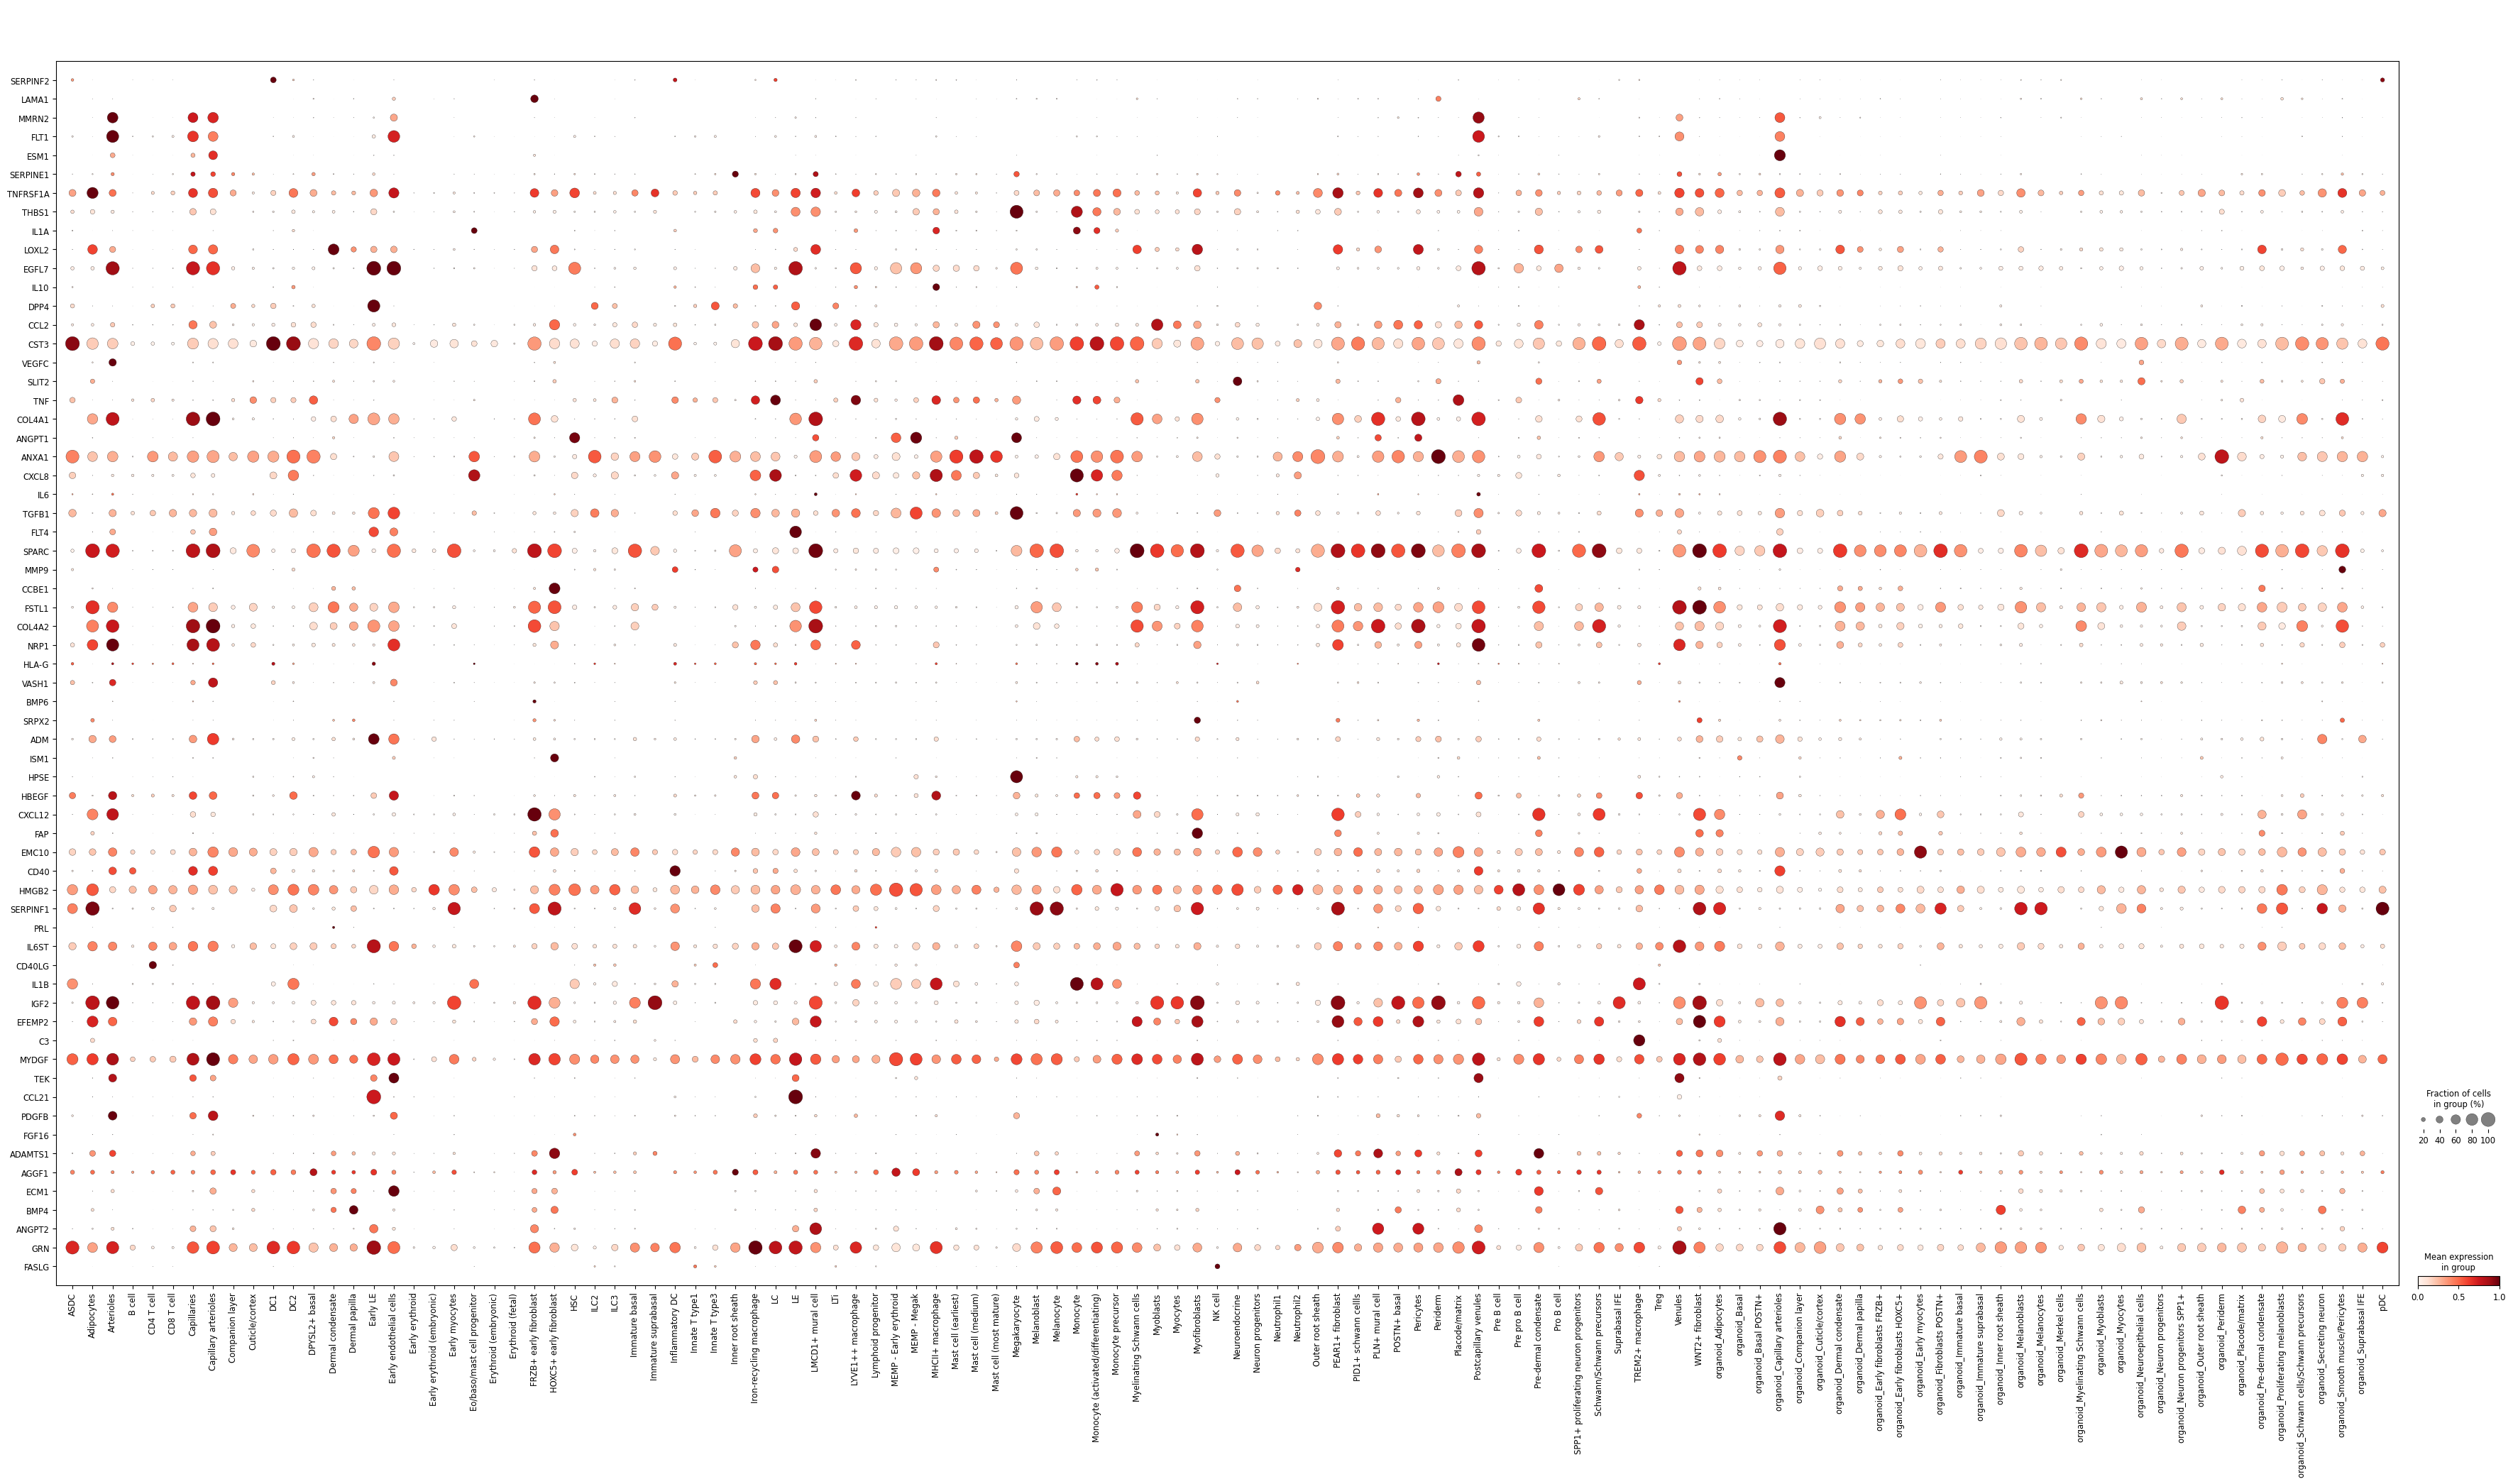

In [62]:
sc.pl.dotplot(pdata2, le_gene_up, groupby='new_combined_anno', standard_scale='var',swap_axes='True')

### Anti-angiogenic factors by Dermal papilla

In [16]:
list(pdata2.obs['new_combined_anno'].unique())

['LYVE1++ macrophage',
 'Monocyte (activated/differentiating)',
 'Eo/baso/mast cell progenitor',
 'DC2',
 'TREM2+ macrophage',
 'Monocyte precursor',
 'Monocyte',
 'WNT2+ fibroblast',
 'Iron-recycling macrophage',
 'NK cell',
 'B cell',
 'LTi',
 'ILC3',
 'Inflammatory DC',
 'MEMP - Early erythroid',
 'CD4 T cell',
 'Pro B cell',
 'HSC',
 'Pre B cell',
 'MHCII+ macrophage',
 'LYVE1-hi LE',
 'Pre pro B cell',
 'Innate T type1',
 'CD8 T cell',
 'Myocytes',
 'pDC',
 'Mast cell (most mature)',
 'DC1',
 'Mast cell (medium)',
 'Capillaries',
 'Neutrophil2',
 'Capillary arterioles',
 'LC',
 'Megakaryocyte',
 'MEMP - Megak',
 'Mast cell (earliest)',
 'Erythroid (fetal)',
 'Myoblasts',
 'Myofibroblasts',
 'Pre-dermal condensate',
 'HOXC5+ early fibroblast',
 'PEAR1+ fibroblast',
 'Pericytes',
 'FRZB+ early fibroblast',
 'Early erythroid (embryonic)',
 'Early myocytes',
 'Neuron progenitors',
 'Myelinating Schwann cells',
 'Schwann/Schwann precursors',
 'LMCD1+ mural cell',
 'PLN+ mural cell',
 '

In [17]:
DP = pdata2[pdata2.obs['new_combined_anno'].isin(['Dermal papilla','organoid_Dermal papilla'])]
DP.obs['new_combined_anno'].unique()

array(['Dermal papilla', 'organoid_Dermal papilla'], dtype=object)

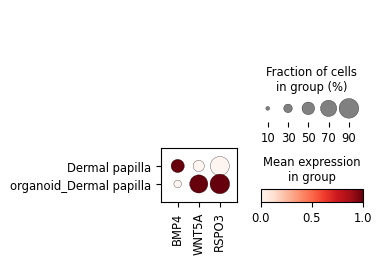

In [18]:
sc.pl.dotplot(DP,['BMP4','WNT5A','RSPO3'],groupby='new_combined_anno',standard_scale='var')
#sc.pl.dotplot(DP,['BMP4','WNT5A','RSPO3'],groupby='new_combined_anno',standard_scale='var',save='fig5_DP_factors.pdf')

### Pro-angiogenic factors by immune, fetal and organoid cells

In [68]:
list(pdata2.obs['new_combined_anno'].unique())

['LYVE1++ macrophage',
 'Monocyte (activated/differentiating)',
 'Eo/baso/mast cell progenitor',
 'DC2',
 'TREM2+ macrophage',
 'Monocyte precursor',
 'Monocyte',
 'WNT2+ fibroblast',
 'Iron-recycling macrophage',
 'NK cell',
 'B cell',
 'LTi',
 'ILC3',
 'Inflammatory DC',
 'MEMP - Early erythroid',
 'CD4 T cell',
 'Pro B cell',
 'HSC',
 'Pre B cell',
 'MHCII+ macrophage',
 'LE',
 'Pre pro B cell',
 'Innate T type1',
 'CD8 T cell',
 'Myocytes',
 'pDC',
 'Mast cell (most mature)',
 'DC1',
 'Mast cell (medium)',
 'Capillaries',
 'Neutrophil2',
 'Capillary arterioles',
 'LC',
 'Megakaryocyte',
 'MEMP - Megak',
 'Mast cell (earliest)',
 'Erythroid (fetal)',
 'Myoblasts',
 'Myofibroblasts',
 'Pre-dermal condensate',
 'HOXC5+ early fibroblast',
 'PEAR1+ fibroblast',
 'Pericytes',
 'FRZB+ early fibroblast',
 'Early erythroid (embryonic)',
 'Early myocytes',
 'Neuron progenitors',
 'Myelinating Schwann cells',
 'Schwann/Schwann precursors',
 'LMCD1+ mural cell',
 'PLN+ mural cell',
 'ILC2',
 '

In [69]:
#create new annotation column keeping myeloid cells/endothelial cells as is but grouping others

pdata2.obs['regrouped_anno']=pdata2.obs['new_combined_anno']
pdata2.obs['regrouped_anno']=pdata2.obs['regrouped_anno'].astype('str')

pdata2.obs.loc[~pdata2.obs['new_combined_anno'].isin(['LYVE1++ macrophage',
'Monocyte (activated/differentiating)',
'TREM2+ macrophage',
'Monocyte precursor',
'Monocyte',
'Iron-recycling macrophage',
'MHCII+ macrophage',
'LC',                                                 
'Capillaries',
'Capillary arterioles',                                                     
'Postcapillary venules',
'Early endothelial cells',
'Arterioles', 
'Venules',                                             
]), "regrouped_anno"] = 'other_fs_cells'

list(pdata2.obs['regrouped_anno'].unique())

['LYVE1++ macrophage',
 'Monocyte (activated/differentiating)',
 'other_fs_cells',
 'TREM2+ macrophage',
 'Monocyte precursor',
 'Monocyte',
 'Iron-recycling macrophage',
 'MHCII+ macrophage',
 'Capillaries',
 'Capillary arterioles',
 'LC',
 'Postcapillary venules',
 'Early endothelial cells',
 'Arterioles',
 'Venules']

In [70]:
#separate organoid cells from other_fs_cells
pdata2.obs.loc[pdata2.obs["dataset"].isin(['organoid']), "regrouped_anno"] = 'organoid_cells'

In [71]:
print(pdata2.obs['regrouped_anno'].unique())

['LYVE1++ macrophage' 'Monocyte (activated/differentiating)' 'other_fs_cells' 'TREM2+ macrophage' 'Monocyte precursor' 'Monocyte'
 'Iron-recycling macrophage' 'MHCII+ macrophage' 'Capillaries' 'Capillary arterioles' 'LC' 'Postcapillary venules' 'Early endothelial cells'
 'Arterioles' 'Venules' 'organoid_cells']


In [72]:
#check
check1= pdata2[pdata2.obs['regrouped_anno']=='organoid_cells']
list(check1.obs['new_combined_anno'].unique())

['organoid_Fibroblasts POSTN+',
 'organoid_Dermal condensate',
 'organoid_Pre-dermal condensate',
 'organoid_Placode/matrix',
 'organoid_Basal',
 'organoid_Outer root sheath',
 'organoid_Basal POSTN+',
 'organoid_Adipocytes',
 'organoid_Inner root sheath',
 'organoid_Dermal papilla',
 'organoid_Cuticle/cortex',
 'organoid_Suprabasal IFE',
 'organoid_Companion layer',
 'organoid_Smooth muscle/Pericytes',
 'organoid_Melanoblasts',
 'organoid_Melanocytes',
 'organoid_Secreting neuron',
 'organoid_Proliferating melanoblasts',
 'organoid_Early fibroblasts HOXC5+',
 'organoid_Schwann cells/Schwann precursors',
 'organoid_Myelinating Schwann cells',
 'organoid_Immature basal',
 'organoid_Myocytes',
 'organoid_Early fibroblasts FRZB+',
 'organoid_Capillary arterioles',
 'organoid_Neuron progenitors SPP1+',
 'organoid_Periderm',
 'organoid_Neuroepithelial cells',
 'organoid_Immature suprabasal',
 'organoid_Merkel cells',
 'organoid_Early myocytes',
 'organoid_Neuron progenitors',
 'organoid_Myo

In [73]:
check2= pdata2[pdata2.obs['regrouped_anno']=='other_fs_cells']
list(check2.obs['new_combined_anno'].unique())

['Eo/baso/mast cell progenitor',
 'DC2',
 'WNT2+ fibroblast',
 'NK cell',
 'B cell',
 'LTi',
 'ILC3',
 'Inflammatory DC',
 'MEMP - Early erythroid',
 'CD4 T cell',
 'Pro B cell',
 'HSC',
 'Pre B cell',
 'LE',
 'Pre pro B cell',
 'Innate T type1',
 'CD8 T cell',
 'Myocytes',
 'pDC',
 'Mast cell (most mature)',
 'DC1',
 'Mast cell (medium)',
 'Neutrophil2',
 'Megakaryocyte',
 'MEMP - Megak',
 'Mast cell (earliest)',
 'Erythroid (fetal)',
 'Myoblasts',
 'Myofibroblasts',
 'Pre-dermal condensate',
 'HOXC5+ early fibroblast',
 'PEAR1+ fibroblast',
 'Pericytes',
 'FRZB+ early fibroblast',
 'Early erythroid (embryonic)',
 'Early myocytes',
 'Neuron progenitors',
 'Myelinating Schwann cells',
 'Schwann/Schwann precursors',
 'LMCD1+ mural cell',
 'PLN+ mural cell',
 'ILC2',
 'Lymphoid progenitor',
 'SPP1+ proliferating neuron progenitors',
 'Adipocytes',
 'Neutrophil1',
 'PID1+ schwann cellls',
 'Early LE',
 'Neuroendocrine',
 'Innate T type3',
 'Treg',
 'ASDC',
 'Periderm',
 'Melanocyte',
 'Me

In [74]:
#re-order cell types
pdata2.obs['regrouped_anno'] = pdata2.obs['regrouped_anno'].astype('category')
pdata2.obs['regrouped_anno'].cat.reorder_categories([
'Iron-recycling macrophage',
'LYVE1++ macrophage',
'MHCII+ macrophage', 
'TREM2+ macrophage',
'Monocyte precursor',
'Monocyte',
'Monocyte (activated/differentiating)',
'LC',
'Early endothelial cells',
'Capillary arterioles',
'Arterioles', 
'Capillaries',                                                 
'Postcapillary venules',
'Venules',   
'other_fs_cells',
'organoid_cells'], inplace=True)

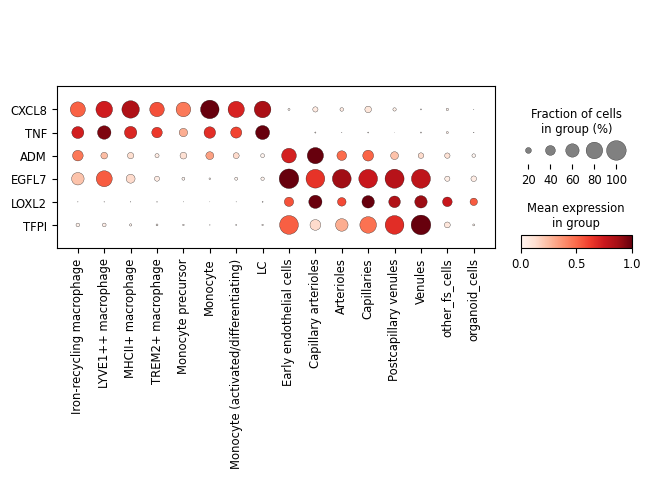

In [75]:
#plot pro-angiogenic factors expression across regrouped celltypes
proangiogenic_factors =['CXCL8','TNF','ADM','EGFL7',
                 'LOXL2','TFPI']
sc.pl.dotplot(pdata2, proangiogenic_factors, groupby='regrouped_anno',standard_scale='var',swap_axes='True')

In [76]:
##plot pro-angiogenic factors expression across regrouped celltypes with pre-natal vascular endothelial cells grouped together

#create further new annotation column
pdata2.obs['regrouped_anno2']=pdata2.obs['regrouped_anno']
pdata2.obs['regrouped_anno2']=pdata2.obs['regrouped_anno2'].astype('str')
pdata2.obs.loc[pdata2.obs["regrouped_anno2"].isin([
'Capillaries',
'Capillary arterioles',
'Postcapillary venules',
'Early endothelial cells', 
'Arterioles', 
'Venules'
 ]), "regrouped_anno2"] = 'fs_vascular_endothelium'

list(pdata2.obs['regrouped_anno2'].unique())

['LYVE1++ macrophage',
 'Monocyte (activated/differentiating)',
 'other_fs_cells',
 'TREM2+ macrophage',
 'Monocyte precursor',
 'Monocyte',
 'Iron-recycling macrophage',
 'MHCII+ macrophage',
 'fs_vascular_endothelium',
 'LC',
 'organoid_cells']

In [77]:
#re-order cell types
pdata2.obs['regrouped_anno2'] = pdata2.obs['regrouped_anno2'].astype('category')
pdata2.obs['regrouped_anno2'].cat.reorder_categories([
'Iron-recycling macrophage',
'LYVE1++ macrophage',
'MHCII+ macrophage', 
'TREM2+ macrophage',
'Monocyte precursor',
'Monocyte',
'Monocyte (activated/differentiating)',
'LC',
'fs_vascular_endothelium',
'other_fs_cells',
'organoid_cells'], inplace=True)

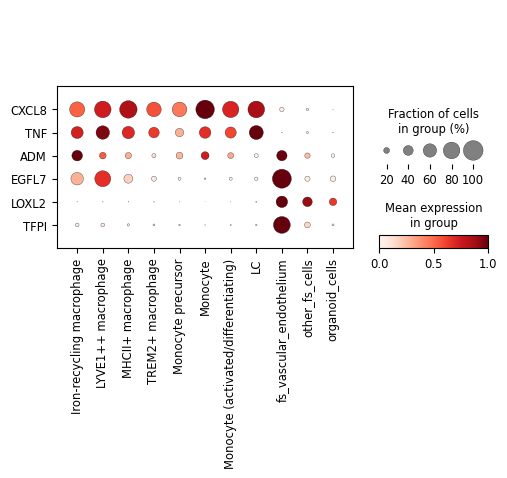

In [78]:
#plot pro-angiogenic factors expression across regrouped celltypes
sc.pl.dotplot(pdata2, proangiogenic_factors ,groupby='regrouped_anno2',standard_scale='var',swap_axes='True')
#sc.pl.dotplot(pdata2, proangiogenic_factors ,groupby='regrouped_anno2',standard_scale='var',swap_axes='True', save='fig5_angiogenic.pdf')

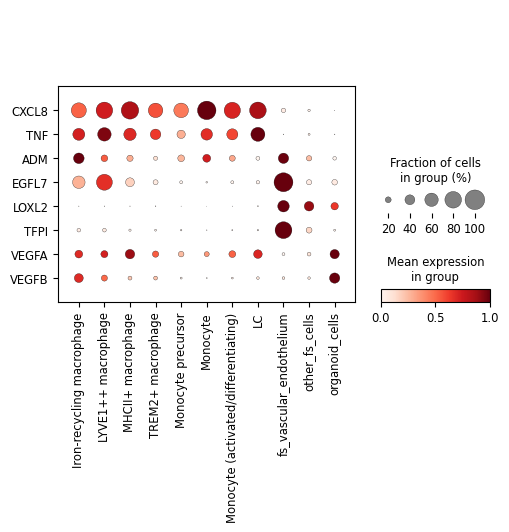

In [81]:
proangiogenic_factors2 =['CXCL8','TNF','ADM','EGFL7','LOXL2','TFPI', 'VEGFA', 'VEGFB']

sc.pl.dotplot(pdata2, proangiogenic_factors2, groupby='regrouped_anno2', standard_scale='var', swap_axes=True)
#sc.pl.dotplot(pdata2, proangiogenic_factors2, groupby='regrouped_anno2',standard_scale='var', swap_axes='True',save='fig5_angiogenic_withVEGF.pdf')

### Ligand-receptor pair expression

In [82]:
#Define dictionary of ligand of interest and corresponding receptors
receptors_dict1 ={'BMP4 R/C':['BMPR2','LRP6'],
              'RSPO3 R/C':['LRP6','FZD8'],
              'WNT5A R/C':['FZD8']}
receptors_dict2 ={
              'TNF R/C':['TNFRSF1A','TNFRSF1B'],
             # 'TFPI R/C':['VLDLR'],
              'ADM R/C':['RAMP2'],
             'CXCL8 R/C':['ACKR1']}

In [83]:
#Slice data object to endothelial cells only
EC = pdata2[pdata2.obs['new_combined_anno'].isin([ 
'Capillaries',
'Capillary arterioles',
'Postcapillary venules',
'Early endothelial cells', 
'Arterioles', 
'Venules',
'organoid_Capillary arterioles'])]
EC

View of AnnData object with n_obs × n_vars = 1721 × 19372
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'day', 'sample_id', 'version', 'week', 'nh3_annot1', 'log1p_n_counts', 'log1p_n_genes', 'n_counts_mito', 'n_counts_ribo

In [85]:
#group prenatal skin endothelial cells together
EC.obs['modified_anno3']=EC.obs['new_combined_anno'].astype('str')
EC.obs.loc[EC.obs['new_combined_anno'].isin([
'Capillaries',
'Capillary arterioles',
'Postcapillary venules',
'Early endothelial cells', 
'Arterioles', 
'Venules',
 ]), 'modified_anno3'] = 'fs_vascular_endothelium'

EC.obs['modified_anno3'] = EC.obs['modified_anno3'].astype('category')
list(EC.obs['modified_anno3'].unique())

['fs_vascular_endothelium', 'organoid_Capillary arterioles']

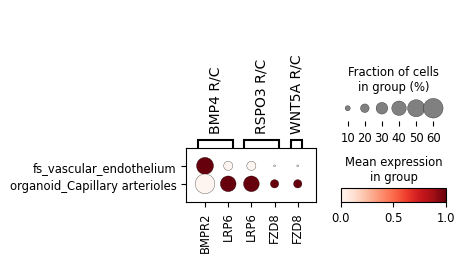

In [86]:
#plot expression of receptors of anti-angiogenic ligands in endothelial cells
sc.pl.dotplot(EC, receptors_dict1, groupby='modified_anno3', standard_scale='var')
#sc.pl.dotplot(EC, receptors_dict1, groupby='modified_anno3', standard_scale='var', save='fig5_antiangiogenic_receptor1.pdf')

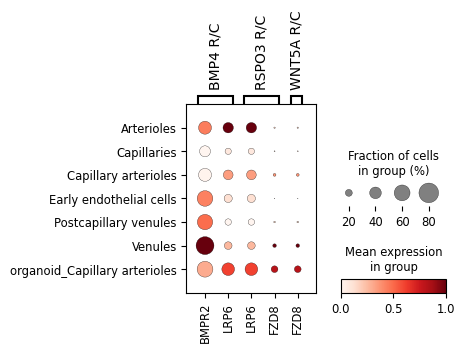

In [89]:
sc.pl.dotplot(EC, receptors_dict1, groupby='new_combined_anno', standard_scale='var')

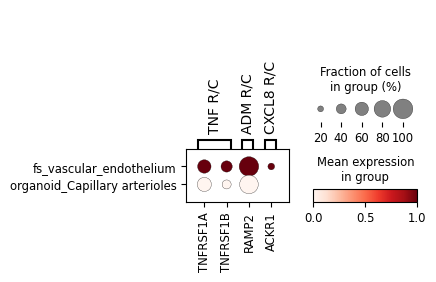

In [90]:
#plot expression of pro-angiogeneic receptors in endothelial cells
sc.pl.dotplot(EC, receptors_dict2, groupby='modified_anno3', standard_scale='var')
#sc.pl.dotplot(EC, receptors_dict2, groupby='modified_anno3', standard_scale='var', save='fig5_angiogenic_receptor1.pdf')

In [87]:
#Slice data object to capillary arterioles cells only
Tip =pdata2[pdata2.obs['new_combined_anno'].isin([ 'Capillary arterioles','organoid_Capillary arterioles'])]
list(Tip.obs['new_combined_anno'].unique())

['Capillary arterioles', 'organoid_Capillary arterioles']

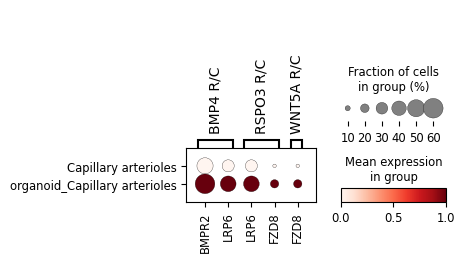

In [88]:
#plot expression of receptors of anti-angiogenic ligands in capillary arterioles
sc.pl.dotplot(Tip, receptors_dict1, groupby='new_combined_anno', standard_scale='var')
#sc.pl.dotplot(Tip, receptors_dict1, groupby='new_combined_anno', standard_scale='var', save='fig5_antiangiogenic_receptor2.pdf')

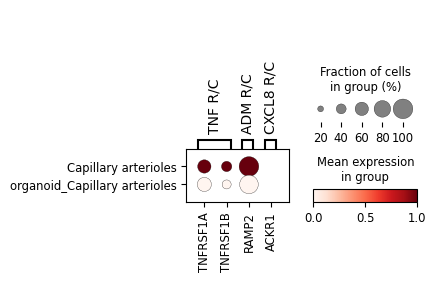

In [91]:
#plot expression of pro-angiogeneic receptors in capillary arteriole cells
sc.pl.dotplot(Tip, receptors_dict2, groupby='new_combined_anno',standard_scale='var')
#sc.pl.dotplot(Tip, receptors_dict2, groupby='new_combined_anno',standard_scale='var', save='fig5_angiogenic_receptor2.pdf')

### Ligand-receptor pair expression - grouped plots

In [22]:
#Define dictionary of ligand of interest and corresponding receptors
receptors_dict1 ={'BMP4 R/C':['BMPR2','LRP6'],
              'RSPO3 R/C':['LRP6','FZD8'],
              'WNT5A R/C':['FZD8']}
receptors_dict2 ={
              'TNF R/C':['TNFRSF1A','TNFRSF1B'],
             # 'TFPI R/C':['VLDLR'],
              'ADM R/C':['RAMP2'],
             'CXCL8 R/C':['ACKR1']}
combined_dict = {'TNF R/C':['TNFRSF1A','TNFRSF1B'],
                 'ADM R/C':['RAMP2'],
                 'CXCL8 R/C':['ACKR1'],
                 'BMP4 R/C':['BMPR2','LRP6'],
                 'RSPO3 R/C':['LRP6','FZD8'],
                'WNT5A R/C':['FZD8'],
                }

In [20]:
#Slice data object to endothelial cells only
EC = pdata2[pdata2.obs['new_combined_anno'].isin([ 
'Capillaries',
'Capillary arterioles',
'Postcapillary venules',
'Early endothelial cells', 
'Arterioles', 
'Venules',
'organoid_Capillary arterioles'])]
EC

View of AnnData object with n_obs × n_vars = 1721 × 19372
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'day', 'sample_id', 'version', 'week', 'nh3_annot1', 'log1p_n_counts', 'log1p_n_genes', 'n_counts_mito', 'n_counts_ribo

In [21]:
#group prenatal skin endothelial cells together
EC.obs['modified_anno3']=EC.obs['new_combined_anno'].astype('str')
EC.obs.loc[EC.obs['new_combined_anno'].isin([
'Capillaries',
'Capillary arterioles',
'Postcapillary venules',
'Early endothelial cells', 
'Arterioles', 
'Venules',
 ]), 'modified_anno3'] = 'fs_vascular_endothelium'

EC.obs['modified_anno3'] = EC.obs['modified_anno3'].astype('category')
list(EC.obs['modified_anno3'].unique())

['fs_vascular_endothelium', 'organoid_Capillary arterioles']

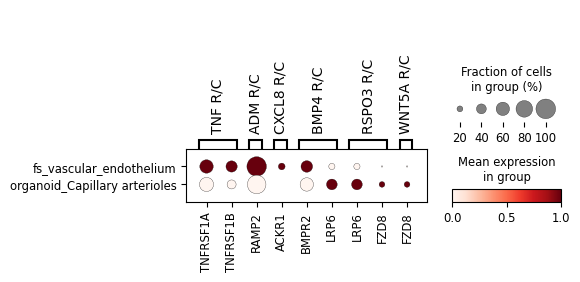

In [28]:
#plot expression of receptors of anti-angiogenic ligands in endothelial cells
sc.pl.dotplot(EC, combined_dict, groupby='modified_anno3', standard_scale='var')
#sc.pl.dotplot(EC, combined_dict, groupby='modified_anno3', standard_scale='var', save='fig5_antiangiogenic_receptor_VE_capart.pdf')

In [24]:
#Slice data object to capillary arterioles cells only
Tip = pdata2[pdata2.obs['new_combined_anno'].isin([ 'Capillary arterioles','organoid_Capillary arterioles'])]
list(Tip.obs['new_combined_anno'].unique())

['Capillary arterioles', 'organoid_Capillary arterioles']

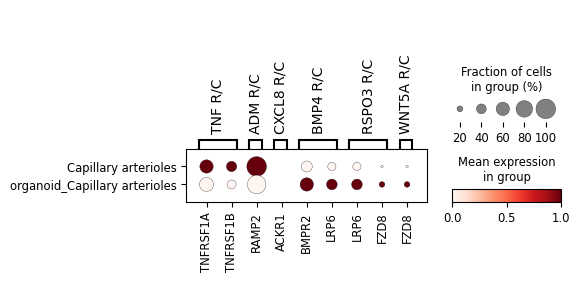

In [29]:
#plot expression of receptors of anti-angiogenic ligands in capillary arterioles
sc.pl.dotplot(Tip, combined_dict, groupby='new_combined_anno', standard_scale='var')
#sc.pl.dotplot(Tip, combined_dict, groupby='new_combined_anno', standard_scale='var', save='fig5_antiangiogenic_receptor_capart_only.pdf')

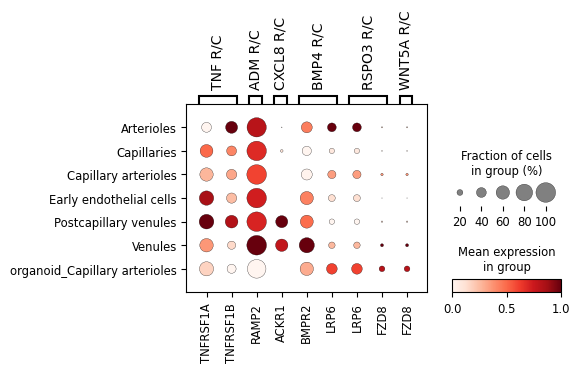

In [27]:
sc.pl.dotplot(EC, combined_dict, groupby='new_combined_anno', standard_scale='var')